# LSTM

В этом ноутбуке продемонстрирована попытка обучения рекурентной нейронной сети, можно сразу отметить, что неудачная.

In [ ]:
import sys
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix
    )
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from navec import Navec
from pymystem3 import Mystem
from nltk.corpus import stopwords
from tqdm.notebook import tqdm


# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

Будем использовать предобученную модель word2vec, обученную командой Natasha. Размерность эмбеддингов 300.

In [ ]:
path = "navec_hudlit_v1_12B_500K_300d_100q.tar"
navec = Navec.load(path)

Загружаем данные для обучения

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобрабатываем данные

In [3]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова и слова, которые меньше 2 символов
    text = " ".join(
        [word for word in text.split() if word not in STOP_WORDS and len(word) >= 2]
    )
    return text


Xpreproc = X.release.apply(preprocessor)

Сформируем словарь слов

In [6]:
vocab = Counter()

for release in Xpreproc:
    vocab.update(release.split())

vocab = dict(
    sorted(filter(lambda x: x[1] > 4, vocab.items()), key=lambda x: x[1], reverse=True)
)
vocab["<unk>"] = 0
vocab["<bos>"] = 0
vocab["<eos>"] = 0
vocab["<pad>"] = 0
vocab = list(vocab.keys())
embedding_matrix = torch.zeros((len(vocab), 300))

for idx, word in enumerate(vocab):
    if word in navec:
        embedding_matrix[idx] = torch.from_numpy(navec[word])
    else:
        embedding_matrix[idx] = torch.normal(mean=0, std=1, size=(300,))

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

Разобьем пресс-релизы на чанки размером 300, и так как у нас очень мало данных эти чанки будут сильно накладываться друг на друга.

In [7]:
chunk_size = 300
def get_chunks(text):
    text = "<bos> " + text + " <eos>"
    word_ids = [
        word_to_idx[word] if word in word_to_idx else word_to_idx["<unk>"]
        for word in text.split()
    ]
    return [word_ids[i : i + chunk_size] for i in range(0, len(word_ids), 25)]

Определим класс датасет

In [8]:
class CBDataset(Dataset):
    def __init__(self, last_release, max_len=chunk_size):
        data = {"input_ids": [], "labels": []}
        for i in range(0, last_release):
            chunks = get_chunks(Xpreproc.iloc[i])
            data["input_ids"].extend(chunks)
            data["labels"].extend([y.iloc[i]] * len(chunks))
        self.data = data
        self.max_len = max_len
        self.label_to_idx = {-1: 0, 0: 1, 1: 2}

    def __len__(self):
        return len(self.data["labels"])

    def __getitem__(self, index):
        input_ids = self.data["input_ids"][index]
        input_ids += [word_to_idx["<pad>"]] * (self.max_len - len(input_ids))
        return (
            torch.LongTensor(input_ids),
            self.label_to_idx[self.data["labels"][index]],
        )

Определяем модель

In [9]:
class ReleaseClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=len(word_to_idx),
        embedding_size=300,
        hidden_size=128,
        num_layers=1,
        bidirectional=True,
        num_classes=3,
        padding_idx=word_to_idx["<pad>"],
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings, embedding_size, padding_idx=padding_idx
        )
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.dropout = nn.Dropout(p=0.5)
        self.output = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        x, (h, c) = self.lstm(emb)
        hh = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        output = self.output(self.dropout(hh))
        return output

Определяем функцию для обучения нашей модели

In [10]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])

    for releases, labels in data_loader:

        # Move Batch to GPU
        reviews = releases.to(device)
        labels = labels.to(device)
        predicted = model(reviews)
        loss = criterion(predicted, labels)

        # Update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update descirption for tqdm
        accuracy = (torch.argmax(predicted, dim=1) == labels).float().mean()
        
        total_loss += loss.item()
        total_predictions = np.append(
            total_predictions,
            torch.argmax(predicted, dim=1).int().cpu().detach().numpy(),
        )
        total_labels = np.append(total_labels, labels.cpu().detach().numpy())
        num_batches += 1
        all_losses.append(loss.detach().item())

    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

Теперь будем проходиться расширяемым окном по нашим пресс-релизам и обучать модели, всего у нас получится 70 обучений. Для каждой модели будем выполнять 1 предсказание для оценки нашей модели.

In [48]:
predictions = []
for i in tqdm(range(30, len(Xpreproc))):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dataset = CBDataset(i, max_len=chunk_size)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = ReleaseClassifier()
    embedding_matrix.requires_grad = True
    model.embedding.weight.data = embedding_matrix
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for _ in range(15):
        train_epoch(
            model, dataloader, criterion=criterion, optimizer=optimizer, device=device
        )

    chunks = get_chunks(Xpreproc.iloc[i])
    for j in range(len(chunks)):
        chunks[j] += [word_to_idx["<pad>"]] * (len(chunks[0]) - len(chunks[j]))
    X_test = torch.LongTensor(chunks).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    y_pred_idx = torch.mode(y_pred.argmax(dim=1)).values.item()
    y_pred_proba = nn.Softmax(dim=1)(y_pred).mean(dim=0).detach().to('cpu')

    idx_to_label = {0: -1, 1: 0, 2: 1}
    predictions.append((idx_to_label[y_pred_idx], y_pred_proba))

  0%|          | 0/70 [00:00<?, ?it/s]

Сформируем предсказания классов и вероятности классов для формирования отчета о нашей модели.

In [ ]:
y_preds = []
y_preds_proba = []
for pred in predictions:
    clss, proba = pred
    y_preds.append(clss)
    y_preds_proba.append(proba)

Формируем отчет

              precision    recall  f1-score   support

        -1.0       0.52      0.52      0.52        23
         0.0       0.39      0.39      0.39        28
         1.0       0.58      0.58      0.58        19

    accuracy                           0.49        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.49      0.49      0.49        70



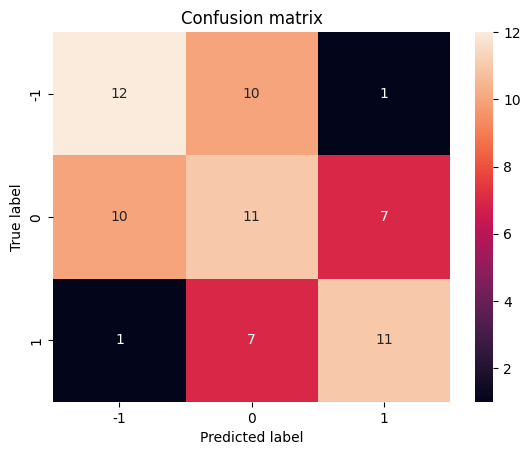

In [59]:
acc = accuracy_score(y[30:], y_preds)
f1 = f1_score(y[30:], y_preds, average="macro")
recall = recall_score(y[30:], y_preds, average="macro")
precision = precision_score(y[30:], y_preds, average="macro")
roc_auc_ovr = roc_auc_score(
    y[30:],
    y_preds_proba,
    average="macro",
    multi_class="ovr",
)
roc_auc_ovo = roc_auc_score(
    y[30:],
    y_preds_proba,
    average="macro",
    multi_class="ovo",
)

print(classification_report(y[30:], y_preds))
cm = confusion_matrix(y[30:], y_preds)
cm = pd.DataFrame(cm, index=["-1", "0", "1"], columns=["-1", "0", 1])
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [61]:
pd.DataFrame({
            'accuracy': acc,
            'f1': f1,
            'recall': recall,
            'precision': precision,
            'roc_auc_ovr': roc_auc_ovr,
            'roc_auc_ovo': roc_auc_ovo,
            }, index=['RNN'])

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
RNN,0.485714,0.497848,0.497848,0.497848,0.66649,0.679089


Можем увидеть, что наша модель не может обучиться на столь небольшом количестве данных, не смотря на то, что слой эмбеддингов мы взяли предобученным.